# Exercises

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize

sns.set_theme(context='notebook',style='white',font_scale=1,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF?

In [10]:
def cc(K, k_est):
  return np.inner(K.ravel(), k_est.ravel()) / (np.linalg.norm(K.ravel()) * np.linalg.norm(k_est.ravel()))

In [3]:
# set up

stimulus_durations = np.array([5, 10, 20, 40, 80, 160, 320, 640]) #s

def generate_K():
  dt = .1
  std_dev = 1
  vf_size = (15,15)
  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  # create receptive field
  size = vf_size # size in pixel of our receptive field
  mu = (8, 8) # center of the gabor pathc
  sigma = (4,4) #size of the gabor patch
  angle = 45 # orientation of the gabor patch
  frequency = .085 # spatial frequency of the gabor patch
  phase = 0 # pahse of the gabor pathc

  xx, yy = np.meshgrid(1. + np.arange(size[0]),
                          1. + np.arange(size[1]))

  # Gaussian envelope
  G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
              - np.power(yy - mu[1], 2) / (2. * sigma[1]))

  # spatial modulation
  phi = np.deg2rad(angle)
  xxr = xx * np.cos(phi)
  yyr = yy * np.sin(phi)
  xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
  Sn = np.cos(xyr + phase)

  K = G * Sn
  K /= np.amax(np.abs(K))

  return K

In [6]:
# functions from the notebook
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):

        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

def cost(k, spike_counts, S,alpha=1):
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)


def grad(k, spike_counts, S):
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

In [ ]:
from tqdm import tqdm

In [11]:
n_trials = 10

dt = .1
std_dev = 1
vf_size = (15,15)
noise_variance = 1
offset = 2.

PCs = np.zeros((len(stimulus_durations), n_trials))

for i, duration in enumerate(stimulus_durations):

  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  for trial in range(n_trials):

    K = generate_K() # randomise for each trial

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    ks = np.dot(K_flat, S_flat.T)
    rate = ks
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    # pearson correlation
    lamda = np.exp(ks)
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x

    PCs[i,trial] = cc(K, K_est[:-1])

<ipython-input-6-724273404>:30: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:30: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:30: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:30: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:30: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
<ipython-input-6-724273404>:30

In [29]:
n_trials = 10

dt = .1
std_dev = 1
vf_size = (15,15)
noise_variance = 1
offset = 2.

PCs_GLM = np.zeros((len(stimulus_durations), n_trials))

for i, duration in enumerate(stimulus_durations):

  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  for trial in range(n_trials):

    K = generate_K() # randomise for each trial

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    ks = np.dot(K_flat, S_flat.T)
    rate = ks
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)


    #


    # # pearson correlation
    # lamda = np.exp(ks)
    # spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    # spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]
    # k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    # res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    # K_est = res.x

    PCs_GLM[i,trial] = cc(K, K_hat)

In [15]:
# now do the same for linear-nonlinerar poisson model

PCs_LNP = np.zeros((len(stimulus_durations), n_trials))
spike_rate = 5

for i, duration in enumerate(stimulus_durations):

  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  for trial in range(n_trials):

    K = generate_K() # randomise for each trial

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


    ks = np.dot(K_flat, S_flat.T)
    # rate = ks
    # rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    # # pearson correlation
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,
                            bins=np.arange(n_bins+1)*dt)[0]

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x

    PCs_LNP[i,trial] = cc(K, K_est[:-1])

<ipython-input-6-724273404>:38: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


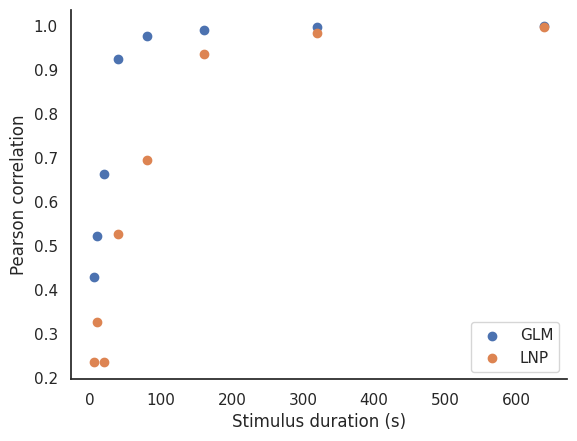

In [30]:
plt.scatter(stimulus_durations, np.mean(PCs_GLM, axis=1),label='GLM')
plt.scatter(stimulus_durations, np.mean(PCs_LNP, axis=1),label='LNP')
plt.legend()
plt.xlabel('Stimulus duration (s)')
plt.ylabel('Pearson correlation')
plt.show()

A higher correlation means a better ability to recover the true RF, so, on average, a longer stimulus duration leads to a better ability to retrieve the true RF. Also, it seems the GLM model is better over time, as it reaches high correlation levels quicker.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [22]:
noise_variances = np.array([2, 4, 6, 8, 10]) # zero removed to avoid error
duration = 100 # s

# compute stds in the end

In [23]:
# now do the same for linear-nonlinerar poisson model

PCs_LNP_noise_vars = np.zeros((len(noise_variances), n_trials))
PCs_GLM_noise_vars = np.zeros((len(noise_variances), n_trials))

for i, duration in enumerate(noise_variances):

  noise_variance = noise_variances[i]

  n_bins = round(duration / float(dt))
  S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

  for trial in range(n_trials):

    K = generate_K() # randomise for each trial

    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    ks = np.dot(K_flat, S_flat.T)
    rate = ks
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

    ################# LNP
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,
                            bins=np.arange(n_bins+1)*dt)[0]

    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)

    K_est = res.x

    PCs_LNP_noise_vars[i,trial] = cc(K, K_est[:-1])

    ################## GLM

    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)


    PCs_GLM_noise_vars[i,trial] = cc(K, K_hat)

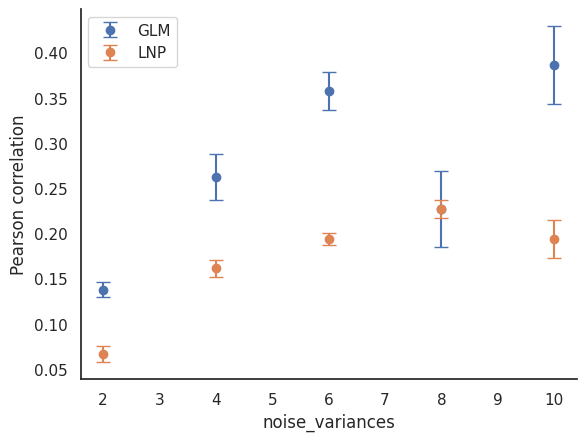

In [25]:
mean_glm = np.mean(PCs_GLM_noise_vars, axis=1)
std_glm = np.std(PCs_GLM_noise_vars, axis=1)

mean_lnp = np.mean(PCs_LNP_noise_vars, axis=1)
std_lnp = np.std(PCs_LNP_noise_vars, axis=1)

# Plot with error bars
plt.errorbar(noise_variances, mean_glm, yerr=std_glm, fmt='o', label='GLM', capsize=5)
plt.errorbar(noise_variances, mean_lnp, yerr=std_lnp, fmt='o', label='LNP', capsize=5)

plt.legend()
plt.xlabel('noise_variances')
plt.ylabel('Pearson correlation')
plt.show()

It seems the noise influences the correlation indeed. In general, having a noise variance of at least 2, the PCs here are lower, but increase as the noise variance increases.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier.




## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates?